In [2]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, \
forecast_by_week, train_test_split,update_deepAR_parameters, \
generate_model_results_by_hp_dict
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
import itertools
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()

In [17]:
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Hyperparameter_results_15_05.csv", sep=',')

hp_search_space = {
    "num_cells": tune.grid_search([60, 140]),
    "num_layers": tune.grid_search([8, 10]),
    "context_length":tune.grid_search([2, 4, 8]),
    "cell_type":tune.grid_search(["lstm"]),
    "epochs":tune.grid_search([40, 60, 80]),
    "use_feat_static_real":tune.grid_search([True, False]),
    "use_feat_dynamic_real":tune.grid_search([True]),
    "use_feat_static_cat":tune.grid_search([False, True]),
    #"cardinality":tune.sample_from(lambda spec:[2]*411 if spec.config.use_feat_static_cat else None),
}

model_results_by_hp, overall_df = generate_model_results_by_hp_dict(df, hp_search_space)

408
There are combinations with fewer modelRuns!!
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
3.0                                    348                     116.0
2.0                                     52                      26.0
4.0                                      8                       2.0


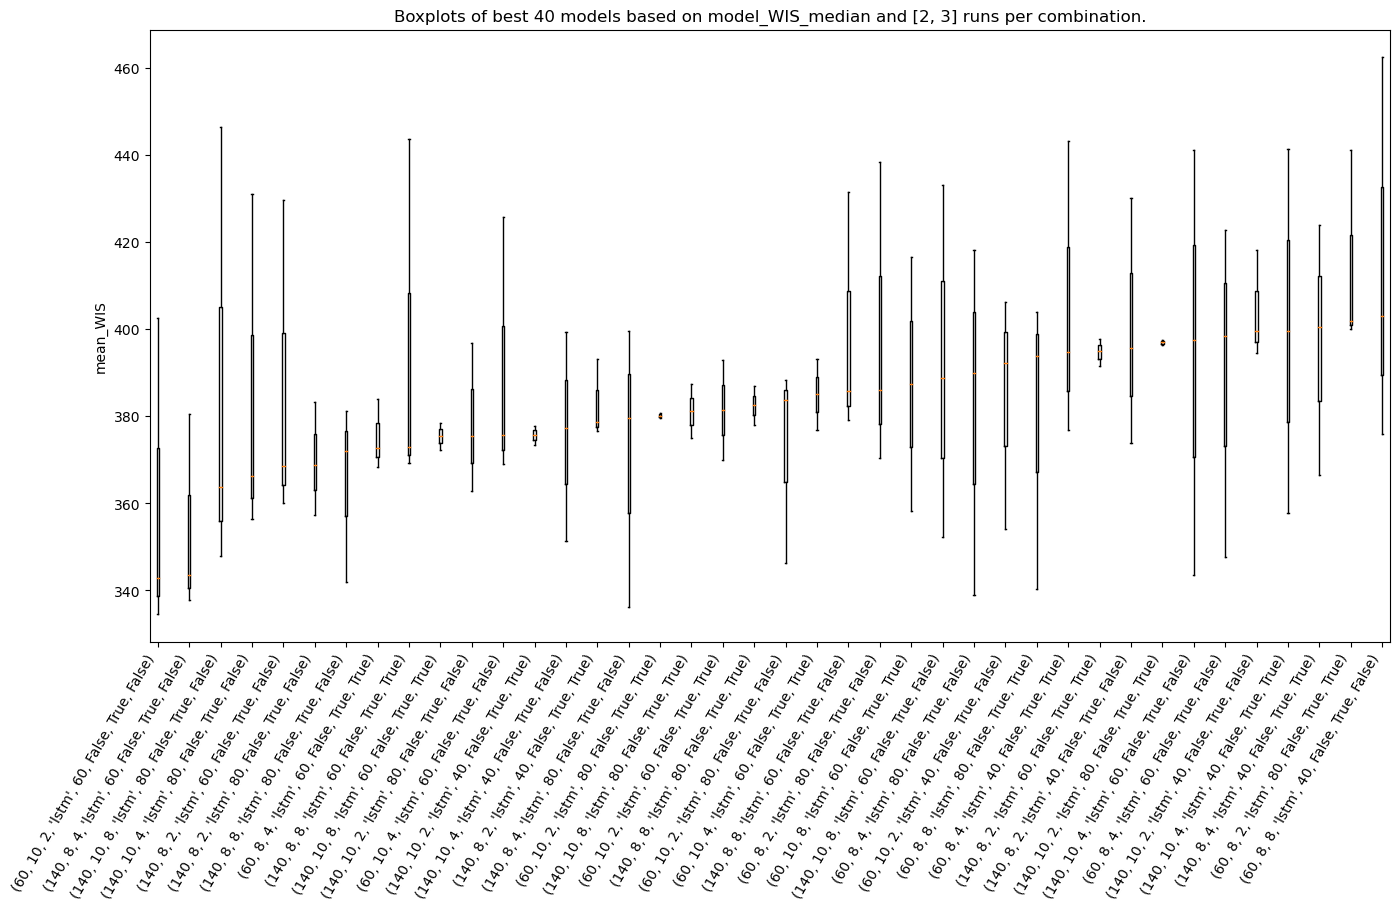

In [11]:
plot_model_results_by_hp(config, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "bp")

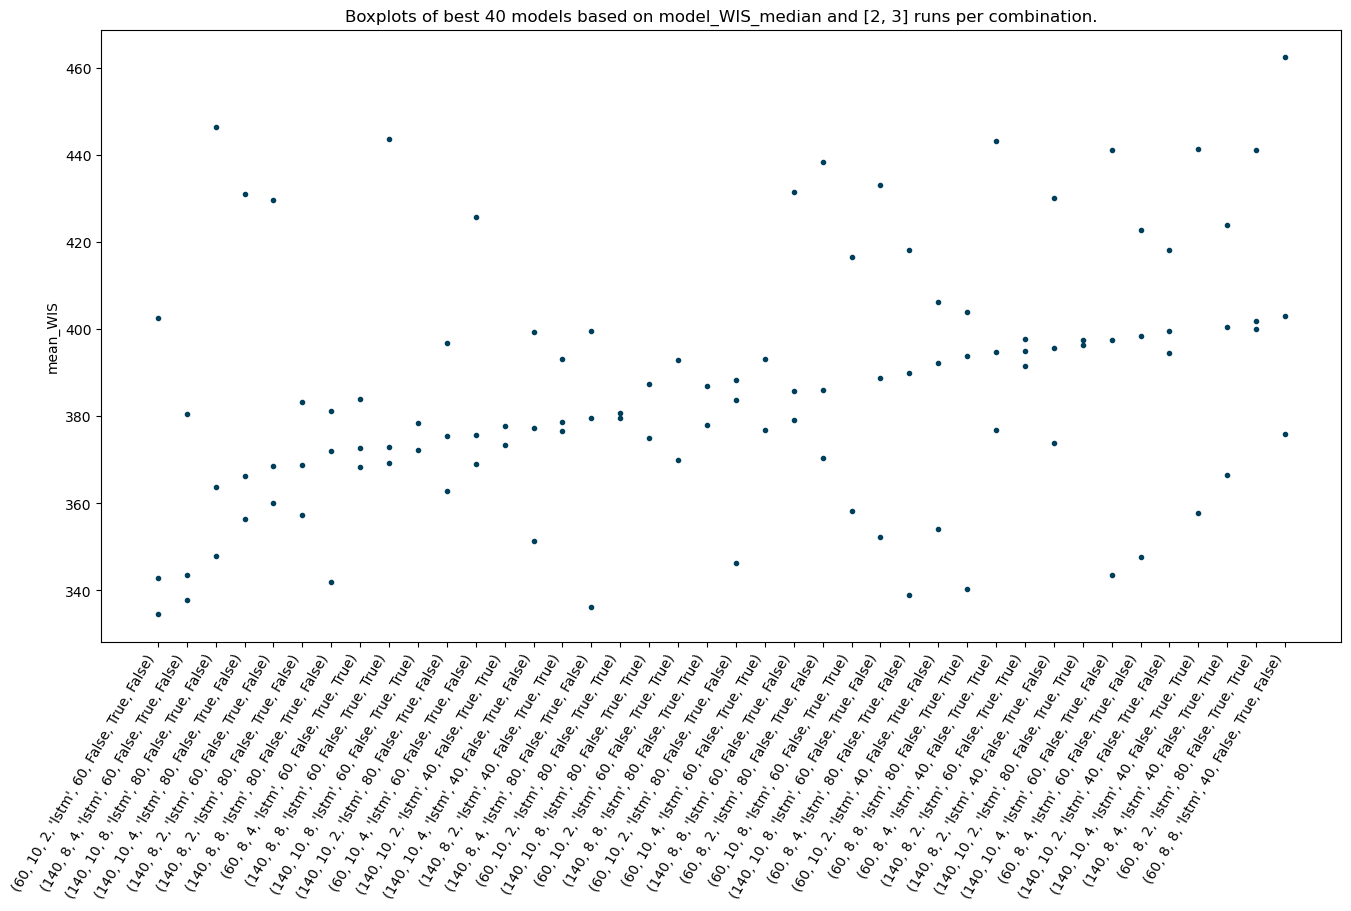

In [12]:

'''
col: "mean_WIS", "time_this_iter_s"
sort_by: "mean_WIS", "time_this_iter_s", "model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median"(, "shape") 
plottype: "unordered"(not ordered), "best" or "worst"
'''
plot_model_results_by_hp(config, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "scatter")

In [13]:
added_cols = ["model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median", "shape"] 
display(overall_df.sort_values("model_WIS_mean")[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates().head(20))

,model_WIS_mean,model_WIS_variance,model_WIS_sd,model_WIS_median,model_time_mean,model_time_variance,model_time_sd,model_time_median,shape,config/cell_type,config/context_length,config/epochs,config/num_cells,config/num_layers,config/use_feat_dynamic_real,config/use_feat_static_cat,config/use_feat_static_real
369,353.904818,538.635779,23.208528,343.481900,6103.897740,31219.665348,176.690875,6013.249428,3.0,lstm,4,60,140,8,True,False,False
377,359.993085,1371.655148,37.035863,342.837765,3915.358529,32240.505170,179.556412,3891.109677,3.0,lstm,2,60,60,10,True,False,False
373,365.095499,421.850153,20.538991,372.100591,7238.603882,31243.197945,176.757455,7191.290450,3.0,lstm,8,80,140,8,True,False,False
87,369.778389,168.976250,12.999087,368.705670,6707.702162,136611.168147,369.609481,6903.313550,3.0,lstm,2,80,140,8,True,False,False
372,371.805984,1051.012690,32.419326,379.552842,6826.513456,104295.057437,322.947453,6842.736548,3.0,lstm,4,80,140,8,True,False,False
240,372.710682,531.782011,23.060399,383.672467,4694.712696,27360.085310,165.408843,4705.996361,3.0,lstm,2,80,60,10,True,False,False
396,375.036573,64.187875,8.011734,372.785558,4081.417745,16215.947498,127.341853,4020.038193,3.0,lstm,4,60,60,8,True,True,False
140,375.353511,20.337046,4.509661,375.353511,7555.711132,25794.369382,160.606256,7555.711132,2.0,lstm,8,60,140,10,True,True,False
279,375.576666,10.402138,3.225235,375.576666,6205.481035,75149.830607,274.134694,6205.481035,2.0,lstm,2,40,140,10,True,True,False
100,376.003237,578.534275,24.052739,377.376829,6072.392302,156091.024923,395.083567,6003.424447,3.0,lstm,4,40,140,10,True,False,False


144
408


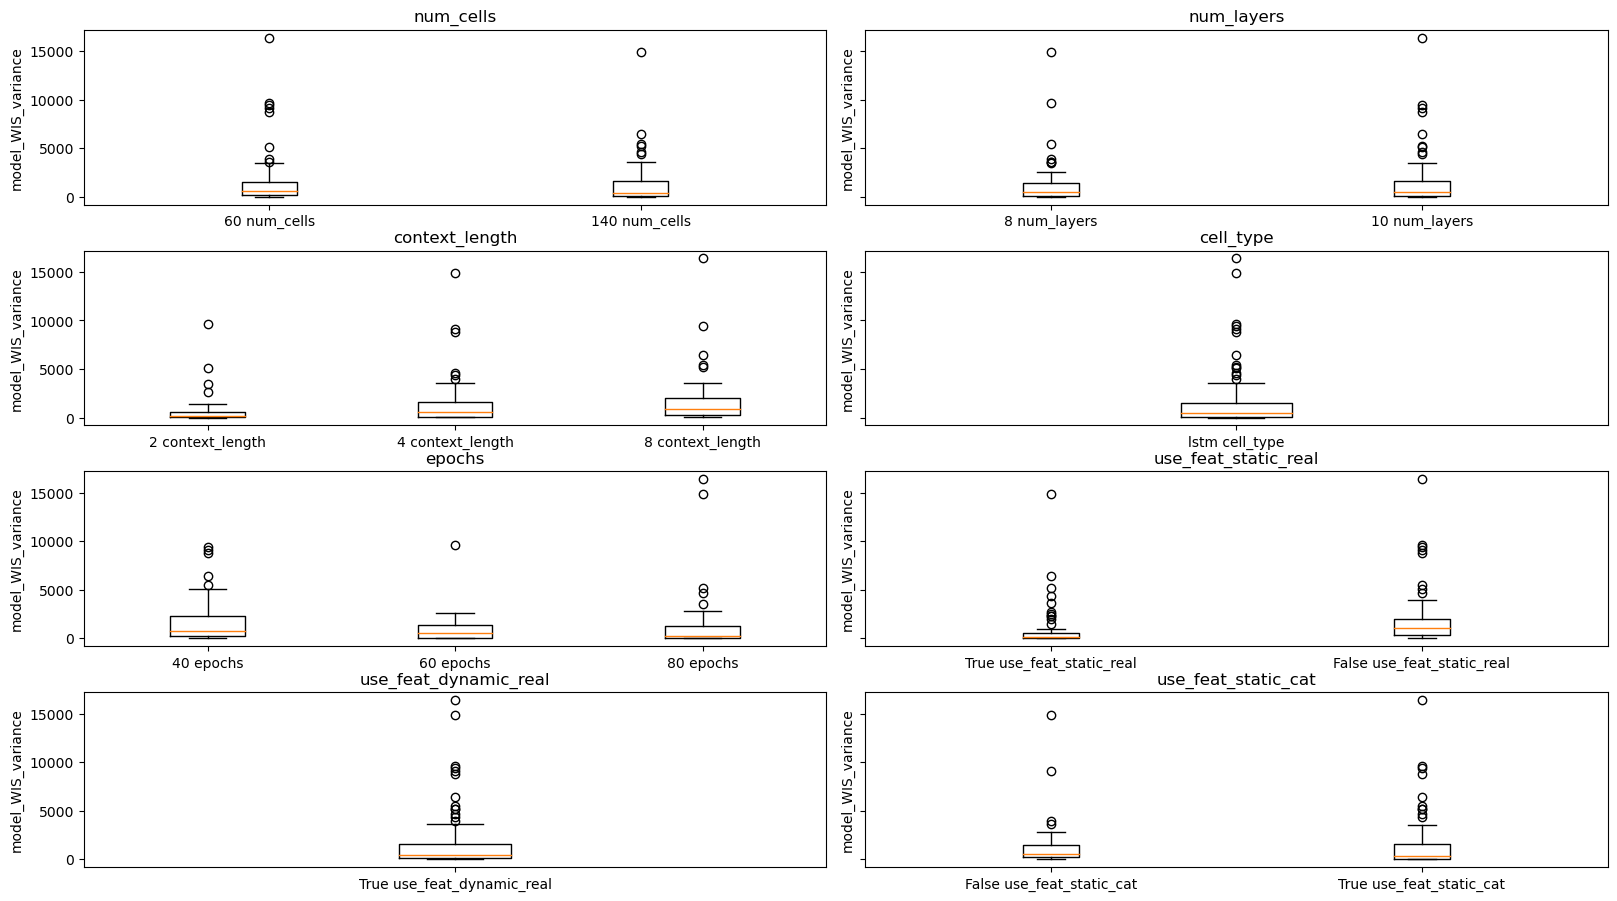

________________


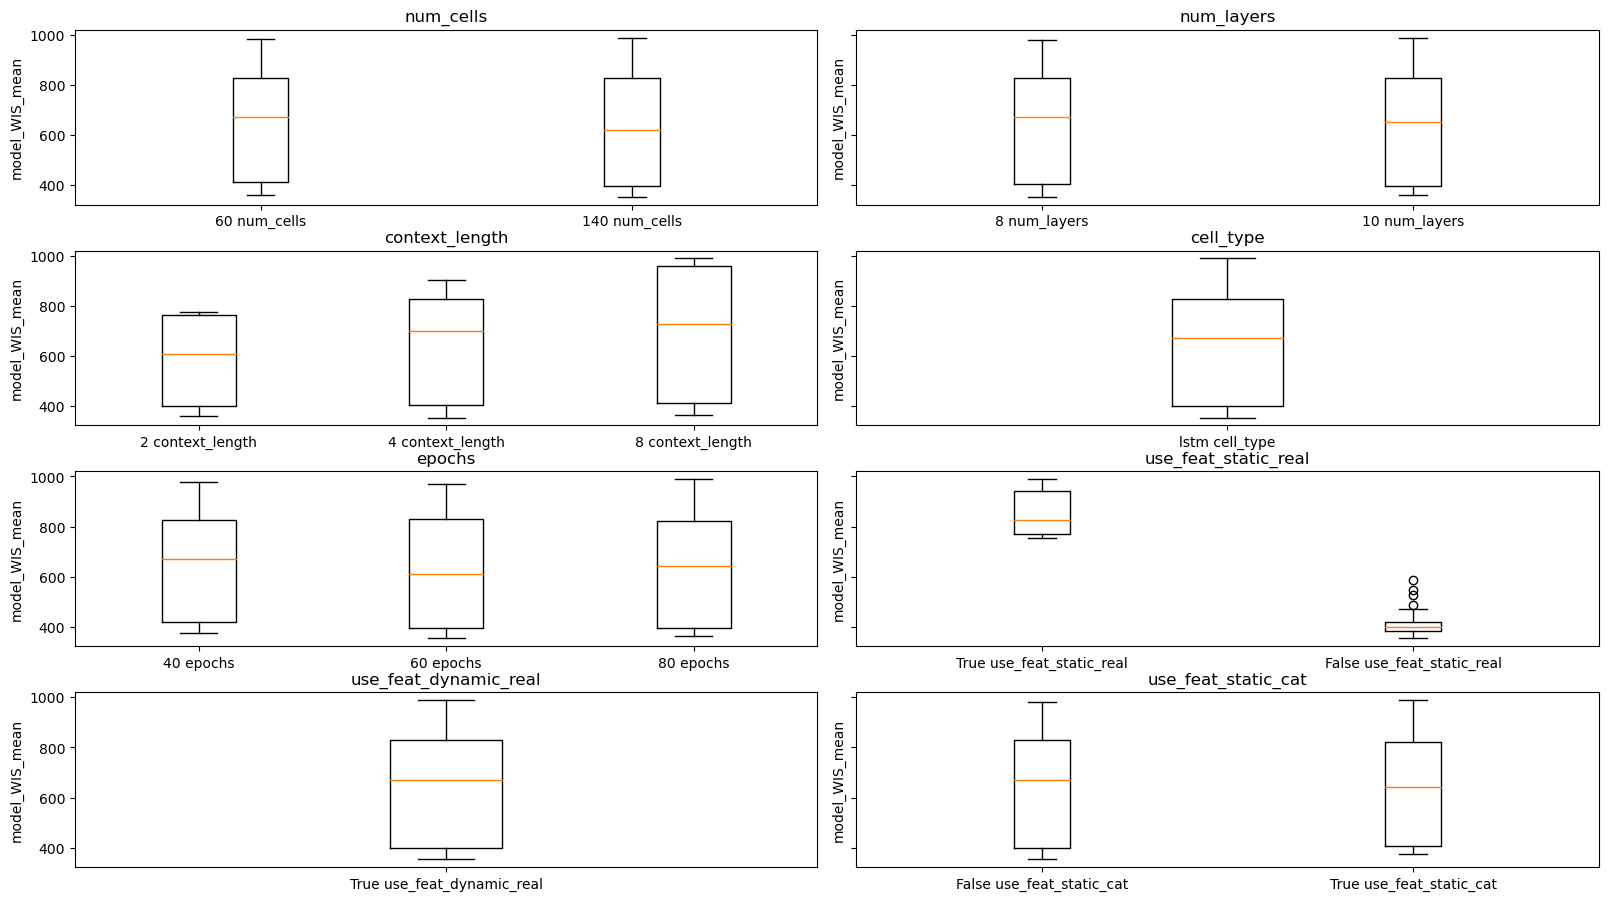

In [14]:
unique_df = overall_df[added_cols+[col for col in df.columns if ("config" in col)&("cardinality" not in col)]].drop_duplicates()
print(len(unique_df))
print(len(overall_df))
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_variance")
print("________________")
hyperparameter_boxplots(unique_df, hp_search_space, col="model_WIS_mean")

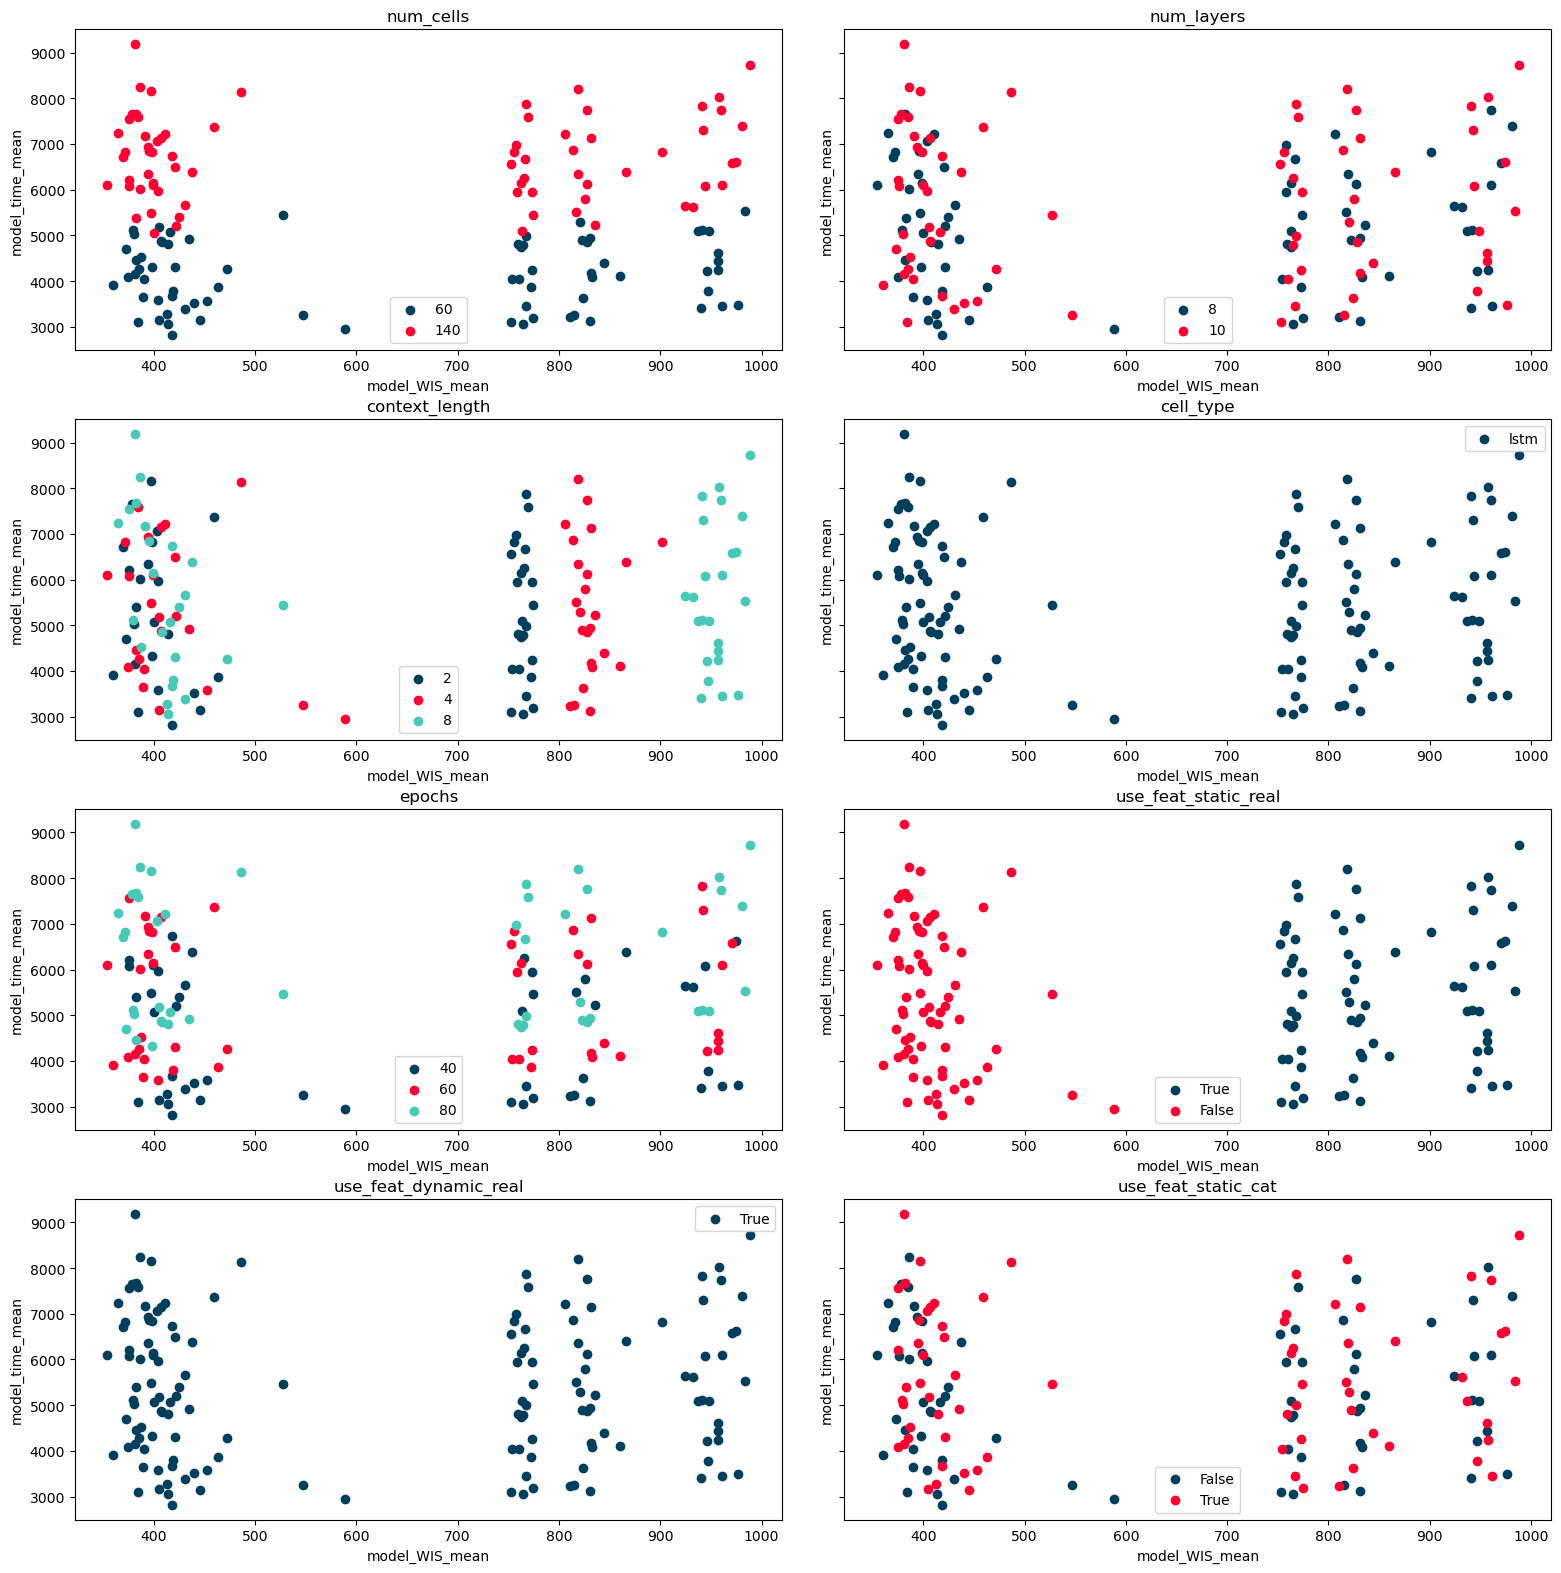

In [15]:
hp_color_plot(config, overall_df, hp_search_space)

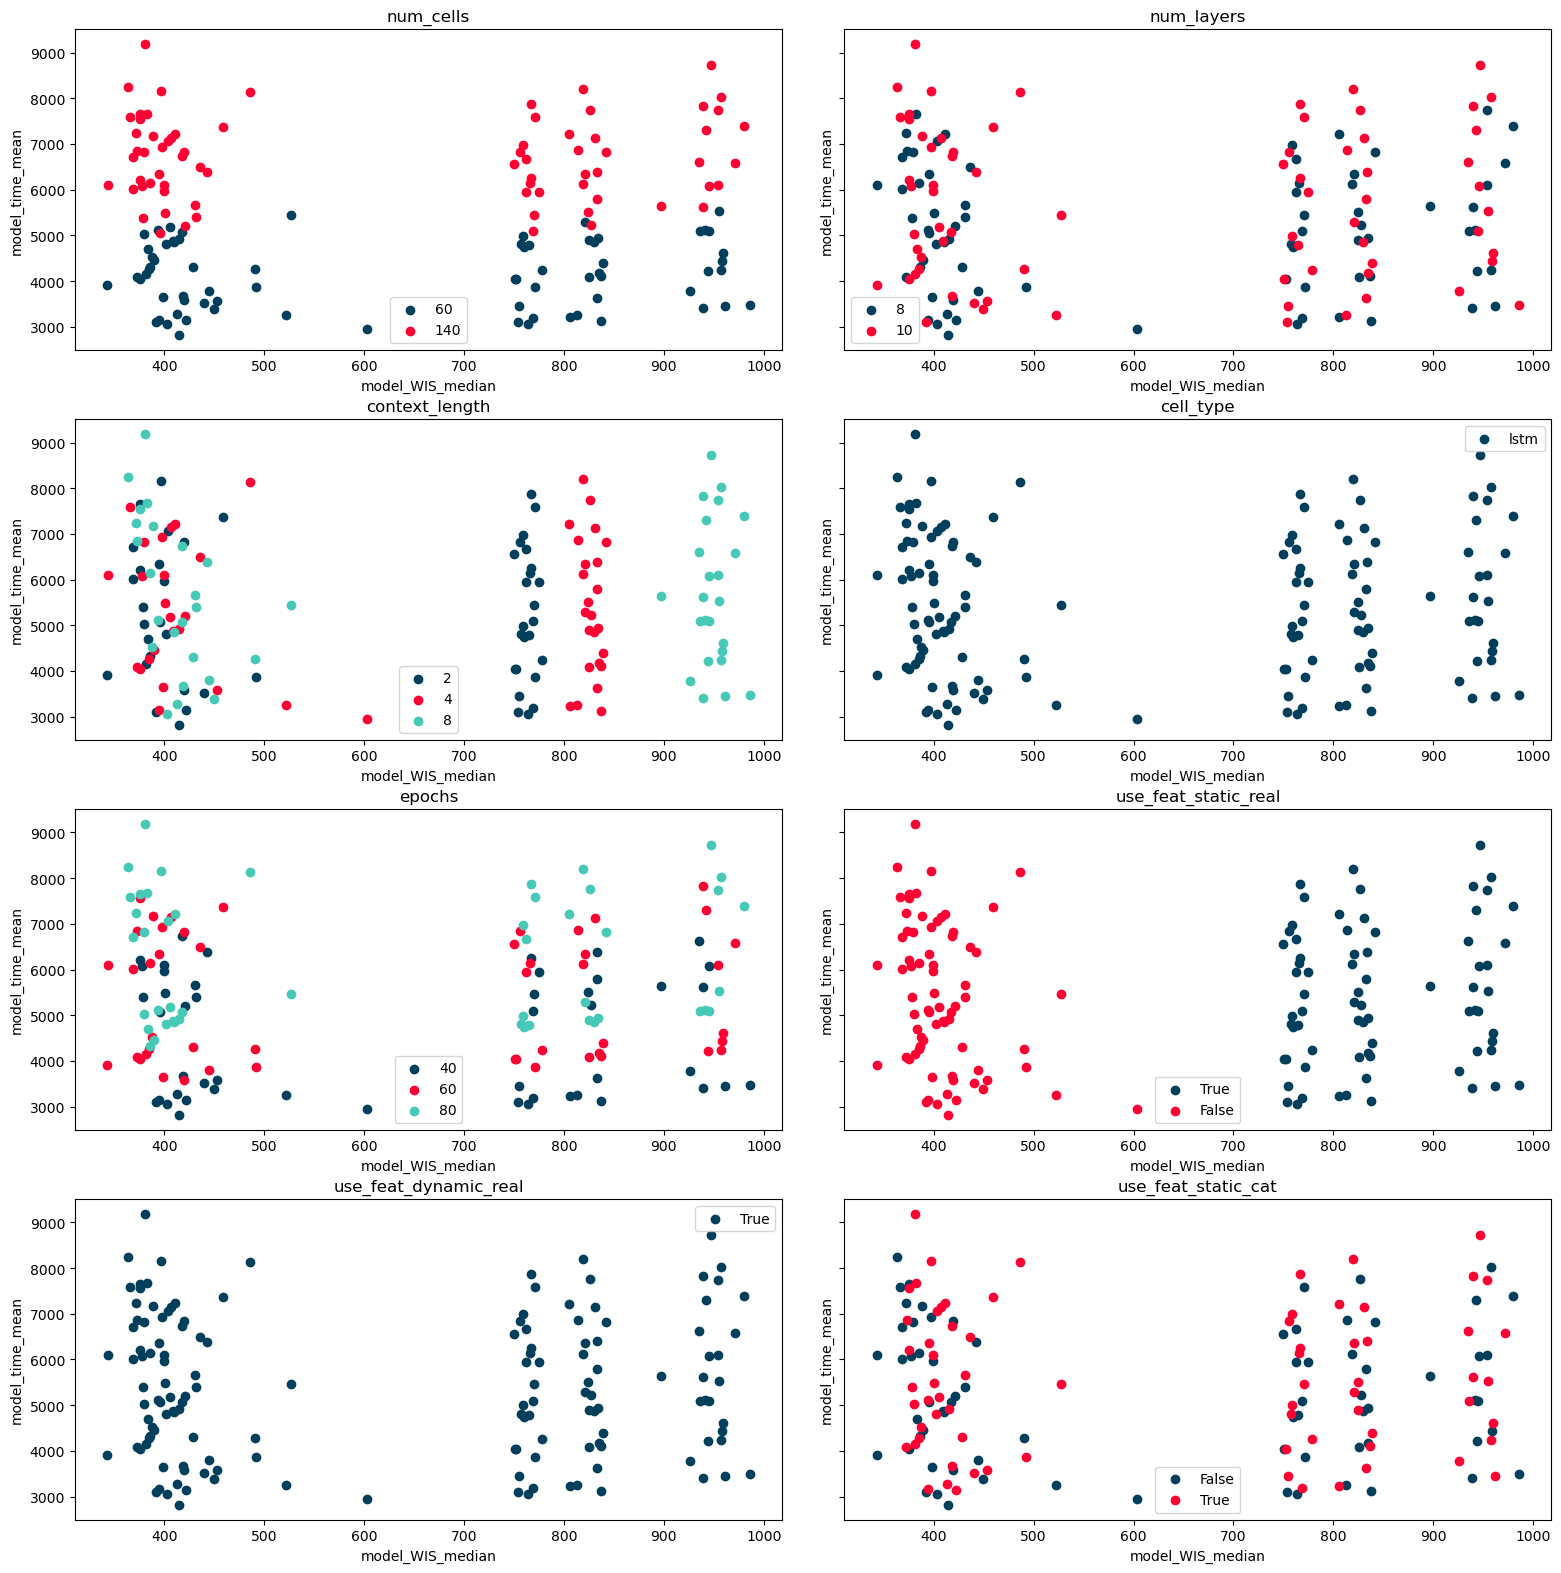

In [16]:
hp_color_plot(config, overall_df, hp_search_space, x_axis="model_WIS_median", y_axis="model_time_mean")